### Importing Libraries

In [1]:
import itertools
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')

### Loading the Dataset

In [2]:
df1 = pd.read_csv("Data/airline-passengers.csv", index_col='Month', parse_dates=True)
df = df1.copy()
df.head()

,total_passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Exploratory Data Analysis

In [3]:
def check_df(dataframe, head=10):

    print('\033[1m' + 20*"*" + ' SHAPE ' + 20*"*" + '\033[0m')
    print(dataframe.shape)

    print('\033[1m' + 20*"*" + ' TYPES ' + 20*"*" + '\033[0m')
    print(dataframe.dtypes)

    print('\033[1m' + 20*"*" + ' NA ' + 20*"*" + '\033[0m')
    print(dataframe.isnull().sum())

    print('\033[1m' + 20*"*" + ' TAIL ' + 20*"*" + '\033[0m')
    print(dataframe.tail())

check_df(df,10)

******************** SHAPE ********************
(144, 1)
******************** TYPES ********************
total_passengers    int64
dtype: object
******************** NA ********************
total_passengers    0
dtype: int64
******************** TAIL ********************
            total_passengers
Month                       
1960-08-01               606
1960-09-01               508
1960-10-01               461
1960-11-01               390
1960-12-01               432


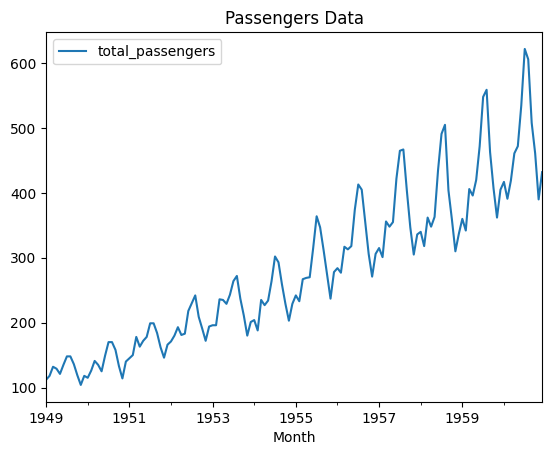

In [4]:
df[['total_passengers']].plot(title='Passengers Data')
plt.show()

When we examined the time series, we could see trend and seasonality. The series is not stationary.

The level can be understood as the average value of the data point in time-series data.
The trend means an increasing or decreasing value in time-series data.
Seasonality means repeating the pattern of a cycle in the time-series data.
Noise means random variance in time-series data.


In [5]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [6]:
df.index.freq = "MS"
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

### Holdout Method

In [7]:
train = df[:120]
test = df[120:]

len(train)

len(test)

### Single Exponential Smoothing (SES)

In [8]:
def ses_optimizer(train, alphas, step=48):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

In [9]:
alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(train, alphas, step=24)

alpha: 0.01 mae: 225.5863
alpha: 0.11 mae: 82.528
alpha: 0.21 mae: 82.8979
alpha: 0.31 mae: 89.8377
alpha: 0.41 mae: 99.0585
alpha: 0.51 mae: 107.5558
alpha: 0.61 mae: 113.7514
alpha: 0.71 mae: 117.2224
alpha: 0.81 mae: 118.1776
alpha: 0.91 mae: 117.2438
best_alpha: 0.11 best_mae: 82.528


In [10]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)

In [11]:
y_pred = ses_model.forecast(24)

In [12]:
def plot_prediction(y_pred, label):
    train["total_passengers"].plot(legend=True, label="TRAIN")
    test["total_passengers"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

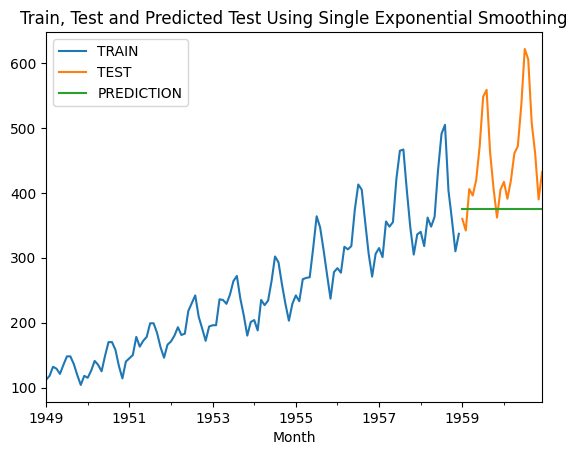

In [13]:
plot_prediction(y_pred, "Single Exponential Smoothing")

SES could not make a successful prediction because there was seasonality and trend in the time series.

### Double Exponential Smoothing (DES)

In [14]:
def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

In [15]:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)


In [16]:
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=24)

alpha: 0.01 beta: 0.01 mae: 54.9512
alpha: 0.01 beta: 0.11 mae: 54.1036
alpha: 0.01 beta: 0.21 mae: 55.5569
alpha: 0.01 beta: 0.31 mae: 57.3247
alpha: 0.01 beta: 0.41 mae: 57.7931
alpha: 0.01 beta: 0.51 mae: 57.9968
alpha: 0.01 beta: 0.61 mae: 57.9637
alpha: 0.01 beta: 0.71 mae: 57.5635
alpha: 0.01 beta: 0.81 mae: 57.3334
alpha: 0.01 beta: 0.91 mae: 57.8984
alpha: 0.11 beta: 0.01 mae: 55.0309
alpha: 0.11 beta: 0.11 mae: 58.4728
alpha: 0.11 beta: 0.21 mae: 69.6339
alpha: 0.11 beta: 0.31 mae: 72.555
alpha: 0.11 beta: 0.41 mae: 78.8168
alpha: 0.11 beta: 0.51 mae: 81.996
alpha: 0.11 beta: 0.61 mae: 77.2262
alpha: 0.11 beta: 0.71 mae: 71.5042
alpha: 0.11 beta: 0.81 mae: 69.0258
alpha: 0.11 beta: 0.91 mae: 67.8408
alpha: 0.21 beta: 0.01 mae: 57.1824
alpha: 0.21 beta: 0.11 mae: 74.992
alpha: 0.21 beta: 0.21 mae: 95.9492
alpha: 0.21 beta: 0.31 mae: 115.3164
alpha: 0.21 beta: 0.41 mae: 139.4303
alpha: 0.21 beta: 0.51 mae: 178.3759
alpha: 0.21 beta: 0.61 mae: 243.4543
alpha: 0.21 beta: 0.71 mae:

In [17]:
des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)

In [18]:
y_pred = des_model.forecast(24)

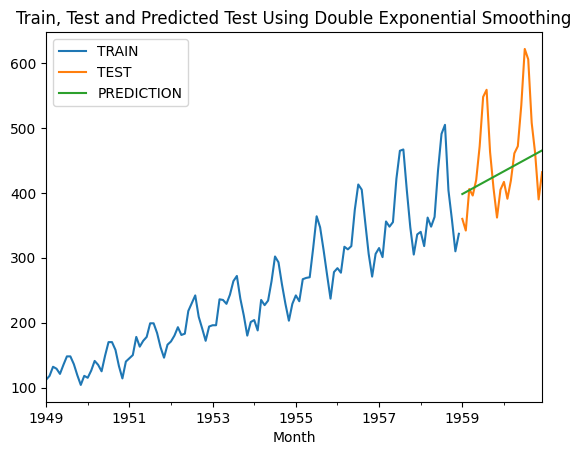

In [19]:
plot_prediction(y_pred, "Double Exponential Smoothing")

It caught the trend in the time series, but could not catch the seasonality.

### Triple Exponential Smoothing (TES) (Holt-Winters)

In [20]:
def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [21]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)

abg = list(itertools.product(alphas, betas, gammas))

In [22]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=24)

[0.1, 0.1, 0.1, 36.83]
[0.1, 0.1, 0.3, 34.88]
[0.1, 0.1, 0.5, 35.91]
[0.1, 0.1, 0.7, 38.72]
[0.1, 0.1, 0.9, 42.55]
[0.1, 0.3, 0.1, 53.96]
[0.1, 0.3, 0.3, 53.0]
[0.1, 0.3, 0.5, 56.98]
[0.1, 0.3, 0.7, 61.38]
[0.1, 0.3, 0.9, 67.17]
[0.1, 0.5, 0.1, 56.76]
[0.1, 0.5, 0.3, 51.72]
[0.1, 0.5, 0.5, 53.39]
[0.1, 0.5, 0.7, 60.08]
[0.1, 0.5, 0.9, 79.29]
[0.1, 0.7, 0.1, 34.04]
[0.1, 0.7, 0.3, 25.93]
[0.1, 0.7, 0.5, 27.81]
[0.1, 0.7, 0.7, 27.91]
[0.1, 0.7, 0.9, 38.32]
[0.1, 0.9, 0.1, 26.87]
[0.1, 0.9, 0.3, 25.32]
[0.1, 0.9, 0.5, 53.88]
[0.1, 0.9, 0.7, 38.38]
[0.1, 0.9, 0.9, 17.78]
[0.3, 0.1, 0.1, 54.54]
[0.3, 0.1, 0.3, 38.34]
[0.3, 0.1, 0.5, 31.57]
[0.3, 0.1, 0.7, 30.99]
[0.3, 0.1, 0.9, 29.23]
[0.3, 0.3, 0.1, 72.71]
[0.3, 0.3, 0.3, 22.6]
[0.3, 0.3, 0.5, 11.99]
[0.3, 0.3, 0.7, 17.11]
[0.3, 0.3, 0.9, 22.32]
[0.3, 0.5, 0.1, 132.33]
[0.3, 0.5, 0.3, 25.74]
[0.3, 0.5, 0.5, 17.3]
[0.3, 0.5, 0.7, 38.38]
[0.3, 0.5, 0.9, 56.82]
[0.3, 0.7, 0.1, 288.32]
[0.3, 0.7, 0.3, 134.86]
[0.3, 0.7, 0.5, 96.77]
[0.3, 0.7, 

In [23]:
tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

In [24]:
y_pred = tes_model.forecast(24)

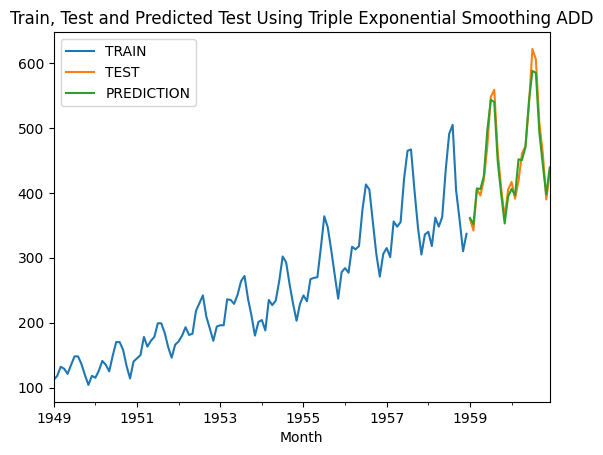

In [25]:
plot_prediction(y_pred, "Triple Exponential Smoothing ADD")

We have achieved the best results so far with the Holt Winter - TES method.

### ARIMA(p, d, q): (Autoregressive Integrated Moving Average)

In [26]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

In [27]:
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model = sm.tsa.ARIMA(train, order=order).fit()
            aic = arima_model.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

In [28]:
best_params_aic = arima_optimizer_aic(train, pdq)

ARIMA(0, 0, 0) AIC=1436.33
ARIMA(0, 0, 1) AIC=1295.42
ARIMA(0, 0, 2) AIC=1229.22
ARIMA(0, 0, 3) AIC=1169.61
ARIMA(0, 1, 0) AIC=1138.81
ARIMA(0, 1, 1) AIC=1127.02
ARIMA(0, 1, 2) AIC=1126.97
ARIMA(0, 1, 3) AIC=1125.45
ARIMA(0, 2, 0) AIC=1171.65
ARIMA(0, 2, 1) AIC=1136.52
ARIMA(0, 2, 2) AIC=1124.36
ARIMA(0, 2, 3) AIC=1124.57
ARIMA(0, 3, 0) AIC=1263.95
ARIMA(0, 3, 1) AIC=1169.49
ARIMA(0, 3, 2) AIC=1140.39
ARIMA(0, 3, 3) AIC=1127.31
ARIMA(1, 0, 0) AIC=1152.40
ARIMA(1, 0, 1) AIC=1138.85
ARIMA(1, 0, 2) AIC=1140.24
ARIMA(1, 0, 3) AIC=1142.18
ARIMA(1, 1, 0) AIC=1130.66
ARIMA(1, 1, 1) AIC=1125.43
ARIMA(1, 1, 2) AIC=1118.10
ARIMA(1, 1, 3) AIC=1119.79
ARIMA(1, 2, 0) AIC=1168.21
ARIMA(1, 2, 1) AIC=1127.97
ARIMA(1, 2, 2) AIC=1122.89
ARIMA(1, 2, 3) AIC=1123.66
ARIMA(1, 3, 0) AIC=1232.81
ARIMA(1, 3, 1) AIC=1166.48
ARIMA(1, 3, 2) AIC=1170.58
ARIMA(1, 3, 3) AIC=1130.67
ARIMA(2, 0, 0) AIC=1141.99
ARIMA(2, 0, 1) AIC=1138.37
ARIMA(2, 0, 2) AIC=1138.68
ARIMA(2, 0, 3) AIC=1135.89
ARIMA(2, 1, 0) AIC=1126.84
A

In [29]:
arima_model = sm.tsa.ARIMA(train, order=best_params_aic).fit()

y_pred = arima_model.forecast(steps=len(test))

y_pred = pd.Series(y_pred, index=test.index)

mean_absolute_error(test, y_pred)

64.01212494280455

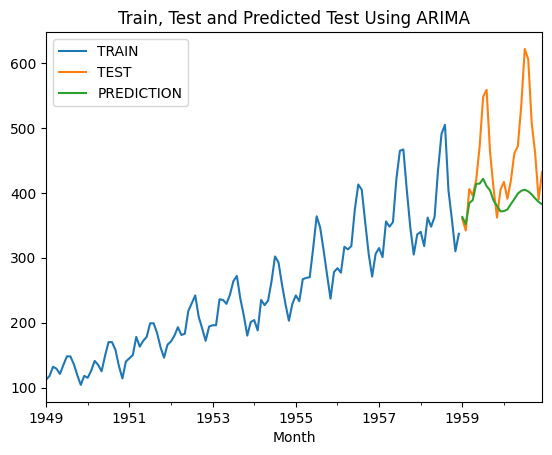

In [30]:
plot_prediction(pd.Series(y_pred, index=test.index), "ARIMA")

It could not capture the seasonality in the time series.

### SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)

In [31]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [32]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

In [33]:
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1680.2792351899682
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1557.632053117491
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1060.4792883429307
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1014.069674752024
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1231.9865853911651
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1185.301097909221
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:969.3781382611646
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:951.6074684656228
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1524.3620853403827
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1403.594235049879
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:967.522569558382
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:942.242509304673
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1136.4998829579354
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1127.8397013046172
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:918.223387602213
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:896.7245834892016
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1138.8088994229304
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1049.4

In [34]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)

sarima_final_model = model.fit(disp=0)

In [35]:
y_pred_test = sarima_final_model.get_forecast(steps=24)

In [36]:
y_pred = y_pred_test.predicted_mean

In [37]:
mean_absolute_error(test, y_pred)

68.5772654544699

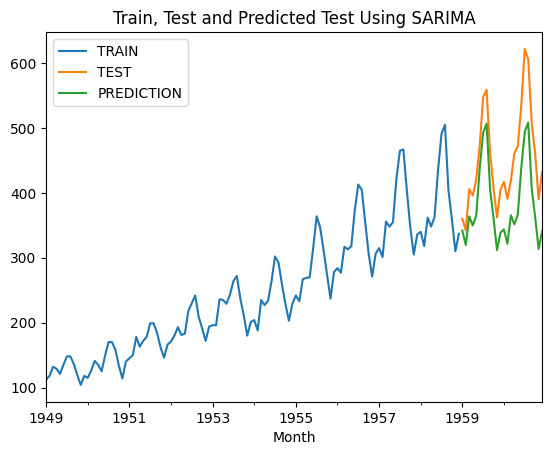

In [38]:
plot_prediction(pd.Series(y_pred, index=test.index), "SARIMA")

It was also able to capture seasonality in the time series.

### SARIMA Optimization - MAE

In [39]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [40]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), float("inf"), None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=24)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)

                # mae = fit_model_sarima(train, val, param, param_seasonal)

                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order

In [41]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:452.25
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:367.2095457540031
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:71.25
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:72.62972633135242
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:74.93608146912112
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:76.79705064327548
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:58.599738774342704
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:30.63273290975219
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:442.6732363260401
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:356.28978572187
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:70.4925284843363
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:71.32051669748289
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:75.4845073678041
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:76.43277472516246
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:61.0138854963242
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:31.821837528011624
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:115.25
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:119.36368412754128
SARIMA(0, 1, 0)x(0, 1, 0, 12

In [42]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

In [43]:
y_pred_test = sarima_final_model.get_forecast(steps=24)

In [44]:
y_pred = y_pred_test.predicted_mean

In [45]:
mean_absolute_error(test, y_pred)

30.63273290975219

It gave better results than AIC.

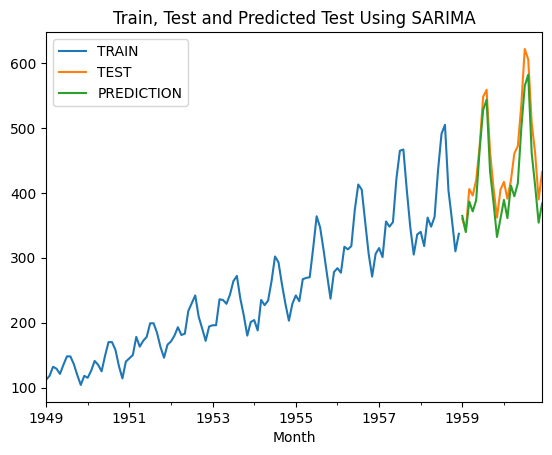

In [46]:
plot_prediction(pd.Series(y_pred, index=test.index), "SARIMA")

### Final Model

In [47]:
pip install nbformat --upgrade

Note: you may need to restart the kernel to use updated packages.


In [48]:
data = {
    "Models": ["SES", "DES", "TES", "ARIMA", "SARIMA"],
    "MAE": [82.528, 54.1036, 11.9947, 64.0122, 30.6261]
}

df_models = pd.DataFrame(data)
fig = px.bar(df_models, x='Models', y='MAE', color='Models',
             labels={'MAE': 'MAE'},
             text='MAE', title="MAE Values for Different Models")

#fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
#fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

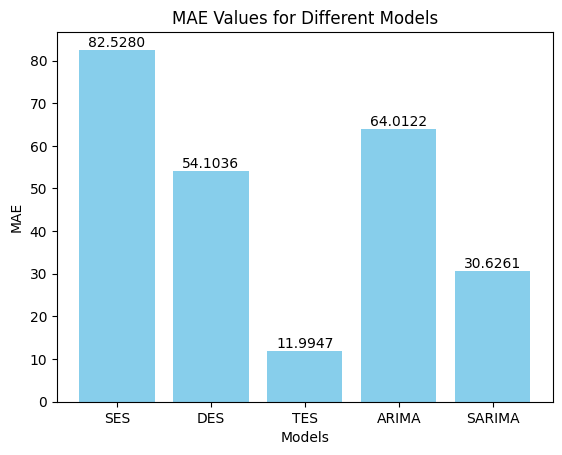

In [49]:
data = {
    "Models": ["SES", "DES", "TES", "ARIMA", "SARIMA"],
    "MAE": [82.528, 54.1036, 11.9947, 64.0122, 30.6261]
}

df_models = pd.DataFrame(data)

plt.bar(df_models['Models'], df_models['MAE'], color='skyblue')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('MAE Values for Different Models')

# Add data labels
for i, value in enumerate(df_models['MAE']):
    plt.text(i, value, f'{value:.4f}', ha='center', va='bottom')

plt.show()

When we evaluated the MAE values, we achieved the best result with TES. We will build our final model with TES and look at the prediction results.

In [50]:
tes_model_final = ExponentialSmoothing(df, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

In [51]:
tes_model_final.forecast(6)

1961-01-01    450.286319
1961-02-01    429.302004
1961-03-01    475.721697
1961-04-01    502.017546
1961-05-01    516.825551
1961-06-01    579.037163
Freq: MS, dtype: float64

The last number of passengers in our dataset was in December 1960. We have now been able to estimate passenger numbers for the first 6 months of 1961. An increasing trend has been observed.

### Summary
In this notebook study, we first briefly analyzed our business problem to understand it correctly and get to know our data set. We observed that there is trend and seasonality in our data set. Then, we tried to obtain the lowest MAE value with smoothing methods such as SES, DES, TES and statistical methods such as ARIMA and SARIMA. We built our final model using all the data with the TES method, which gives the lowest MAE value, and evaluated our prediction results.